# Exercise - VAEs

Use the Fashion MNIST data to solve this exercise. Load the images.

1. Use a VAE to learn a 2D variational representation of the images (i.e. 2 means and 2 standard deviations). Train your VAE. Plot the 2D latent space when you are done.
1. Try to use a VAE with a higher dimensional latent space (such as 5D instead of 2D). Does it achieve a better variational lower bound on the test images?

**Hint**: Consider looking at https://www.tensorflow.org/tutorials/generative/cvae, as they go through some of the same steps.

**Hint**: See https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose for details on transposed convolutions.

**See slides for more details!**

# Setup

This is simply some code to prepare the data. Mostly similar to https://www.tensorflow.org/tutorials/generative/cvae, but with another dataset.

It also prepares some functions for you to use. You do not have to - but are of course welcome to - change any of this code.

**Data preparation**

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

x_train, x_test = x_train / 255, x_test / 255

x_train = x_train.reshape((*x_train.shape, 1))
x_test = x_test.reshape((*x_test.shape, 1))

In [2]:
x_train = np.where(x_train > 0.5, 1, 0).astype('float32')
x_test = np.where(x_test > 0.5, 1, 0).astype('float32')

train_dataset = (tf.data.Dataset.from_tensor_slices(x_train).shuffle(len(x_train)).batch(32))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).shuffle(len(x_test)).batch(32))

**VAE class** 

In [3]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, encoder, decoder):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = encoder
        self.decoder = decoder
    
    def encode(self, x):
        params = self.encoder(x)
        return tf.split(params, num_or_size_splits=2, axis=1) # mean, logvar
        
    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return tf.sigmoid(self.decode(eps))

**Loss function**

In [4]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    vals = -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)

    return tf.reduce_sum(vals, axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)

    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

**Train step function**

In [5]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

**Function to show progress**

In [6]:
def generate_and_show_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.show()

**2D latent space plot**

In [7]:
def plot_2d_latent_images(model, n, image_size=28):
    grid_x = tf.math.ndtri(np.linspace(0.05, 0.95, n))
    grid_y = tf.math.ndtri(np.linspace(0.05, 0.95, n))
    image_width = image_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (image_size, image_size))
            image[i * image_size: (i + 1) * image_size, j * image_size: (j + 1) * image_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

# Exercise 1

Use a VAE to learn a 2D variational representation of the images (i.e. 2 means and 2 standard deviations). Train your VAE. Plot the 2D latent space when you are done.

Let us start by defining our encoder and decoder.

In [8]:
latent_dim = 2

In [9]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, 2, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(64, 3, 2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2 * latent_dim), # 2 since we encode mean and standard deviation
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 9220      
Total params: 28,036
Trainable params: 28,036
Non-trainable params: 0
_________________________________________________________________


In [10]:
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=7*7*32, activation='relu', input_shape=(latent_dim,)),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)), # To get in "image format"
    tf.keras.layers.Conv2DTranspose(64, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, 3, 1, padding='same'),
])
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1568)              4704      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 41,953
Trainable params: 41,953
Non-trainable params: 0
_________________________________________________________________


Now we prepare our model, optimizer, and test batch (to see development as we train).

In [11]:
model = VAE(latent_dim, encoder, decoder)
optimizer = tf.keras.optimizers.Adam(1e-4)
test_sample = next(iter(test_dataset.take(1)))[:16]

Let us run the training.

Epoch: 0, Test set variational lower bound: -223.718994140625


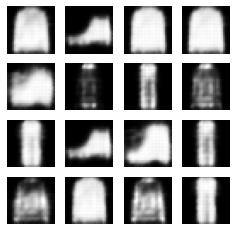

Epoch: 1, Test set variational lower bound: -212.00933837890625


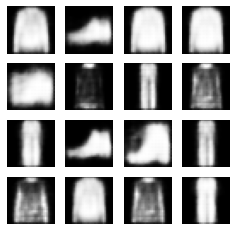

Epoch: 2, Test set variational lower bound: -205.3917999267578


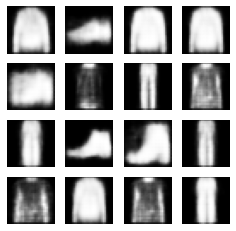

Epoch: 3, Test set variational lower bound: -201.91021728515625


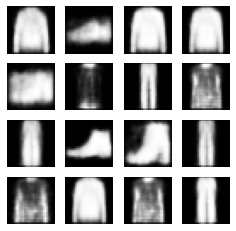

Epoch: 4, Test set variational lower bound: -199.5626983642578


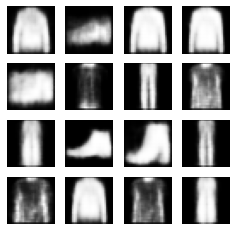

Epoch: 5, Test set variational lower bound: -197.58123779296875


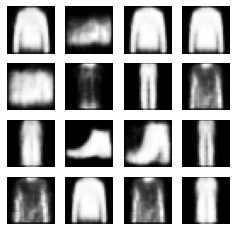

Epoch: 6, Test set variational lower bound: -196.15164184570312


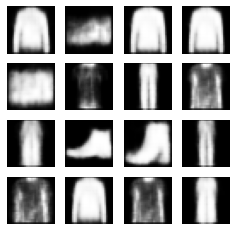

Epoch: 7, Test set variational lower bound: -195.34255981445312


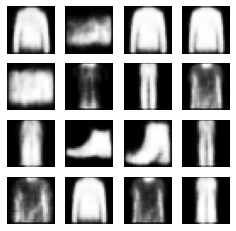

Epoch: 8, Test set variational lower bound: -194.2208709716797


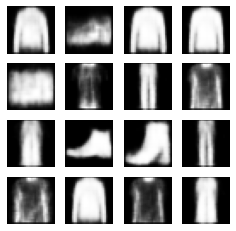

Epoch: 9, Test set variational lower bound: -193.53269958496094


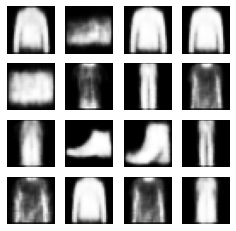

In [12]:
for epoch in range(10):
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    variational_lower_bound = -loss.result()

    print(f'Epoch: {epoch}, Test set variational lower bound: {variational_lower_bound}')
    generate_and_show_images(model, epoch, test_sample)

Let us show the 2D latent space plot.

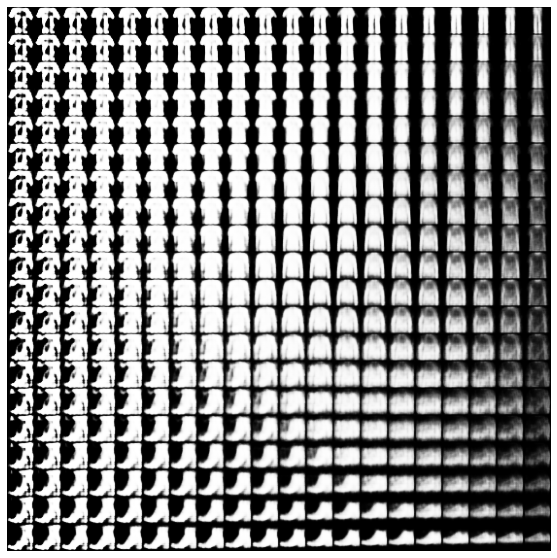

In [13]:
plot_2d_latent_images(model, 20)

# Exercise 2

Try to use a VAE with a higher dimensional latent space (such as 5D instead of 2D). Does it achieve a better variational lower bound on the test images?

Let us start by defining our encoder and decoder - now with larger latent dimensionality.

In [14]:
latent_dim = 5

In [15]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, 2, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(64, 3, 2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2 * latent_dim), # 2 since we encode mean and standard deviation
])
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                23050     
Total params: 41,866
Trainable params: 41,866
Non-trainable params: 0
_________________________________________________________________


In [16]:
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=7*7*32, activation='relu', input_shape=(latent_dim,)),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)), # To get in "image format"
    tf.keras.layers.Conv2DTranspose(64, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, 3, 1, padding='same'),
])
decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1568)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 46,657
Trainable params: 46,657
Non-trainable params: 0
_________________________________________________________________


Now we prepare our model and optimizer (and use the same test sample as in the prior exercise).

In [17]:
model = VAE(latent_dim, encoder, decoder)
optimizer = tf.keras.optimizers.Adam(1e-4)

Let us run the training. We redefine our training step function to allow different shape.

In [18]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch: 0, Test set variational lower bound: -180.82452392578125


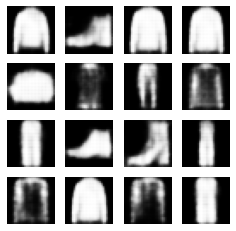

Epoch: 1, Test set variational lower bound: -169.753662109375


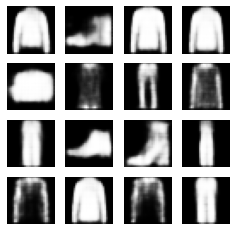

Epoch: 2, Test set variational lower bound: -164.72642517089844


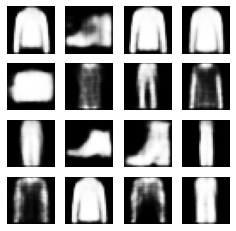

Epoch: 3, Test set variational lower bound: -161.59898376464844


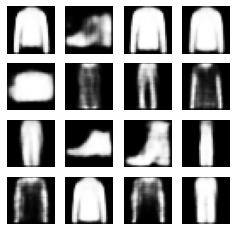

Epoch: 4, Test set variational lower bound: -159.92861938476562


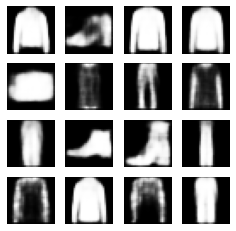

Epoch: 5, Test set variational lower bound: -157.9040069580078


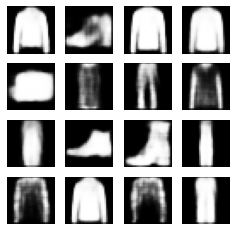

Epoch: 6, Test set variational lower bound: -156.85789489746094


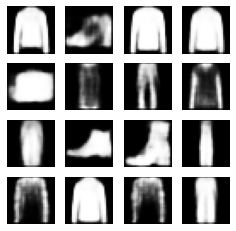

Epoch: 7, Test set variational lower bound: -156.0790252685547


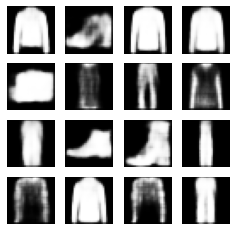

Epoch: 8, Test set variational lower bound: -154.94964599609375


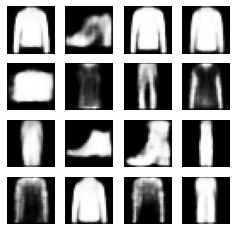

Epoch: 9, Test set variational lower bound: -154.2250213623047


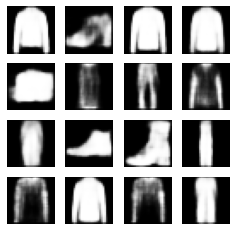

In [19]:
for epoch in range(10):
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    variational_lower_bound = -loss.result()

    print(f'Epoch: {epoch}, Test set variational lower bound: {variational_lower_bound}')
    generate_and_show_images(model, epoch, test_sample)

Note how the variational lower bound is much higher now.

We cannot just use the same function for latent space plot (we now have 5 dimension). And visualizing 5D is difficult!

Let us create a "hack" in the sense of still plotting a 2D space and just fixing the remaining 3 dimensions.

In [20]:
def plot_2d_latent_images_hacky(model, n, digit_size=28):
    grid_x = tf.math.ndtri(np.linspace(0.05, 0.95, n))
    grid_y = tf.math.ndtri(np.linspace(0.05, 0.95, n))
    fixed = tf.math.ndtri(0.5)
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi, fixed, fixed, fixed]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

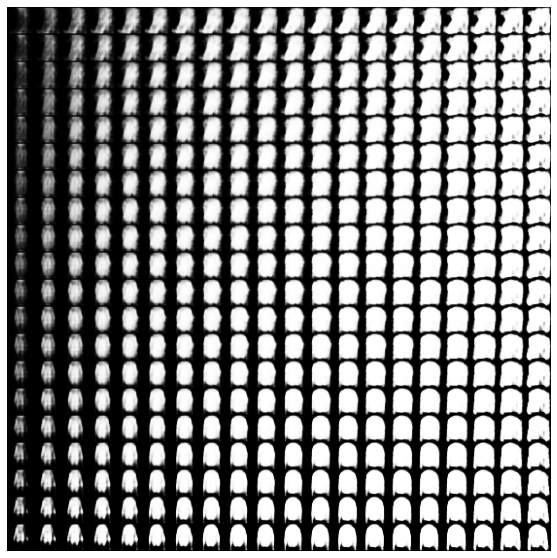

In [21]:
plot_2d_latent_images_hacky(model, 20)

Wauw that was ugly!